# Amazon Topic Modelling

We are given a dataset containing reviews for Amazon products. Our goal is to figure out the major topics in the reviews. We do this via NLP, using BERTopic.

Run the following cell to set everything up.

In [1]:
!pip install autocorrect
!pip install sentence_transformers
!pip install bertopic
!pip install pycld3
!pip install kaleido

import numpy as np
import pandas as pd
import os
from collections import defaultdict
# Language detection
import cld3
# Data visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.io as pio
pio.renderers.default = "svg"
# Preprocessing
import re
from autocorrect import Speller
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
# Embedding
import transformers
from sentence_transformers import SentenceTransformer, util
# Dimensionality reduction
from umap import UMAP
# Clustering
from hdbscan import HDBSCAN
# Tokenisation
from sklearn.feature_extraction.text import CountVectorizer
# Topic modelling
from bertopic import BERTopic
# Weighting
from bertopic.vectorizers import ClassTfidfTransformer
# Topic representation
from bertopic.representation import MaximalMarginalRelevance
# Coherence scoring
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim import corpora
# Hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV
# Serialisation
import joblib

# Set Matplotlib defaults
sns.set_style("darkgrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

# Load data
amazon = pd.read_csv('../input/amazon-product-reviews-dataset/7817_1.csv')

print('Setup complete!')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 622.8/622.8 kB 9.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for autocorrect: filename=autocorrect-2.6.1-py3-none-any.whl size=622364 sha256=56625d494f491c70f02e5b5ecc02f42079d1b6c86c66ff6aebcbea0e48723115
  Stored in directory: /root/.cache/pip/wheels/b5/7b/6d/b76b29ce11ff8e2521c8c7dd0e5bfee4fb1789d76193124343
Successfully built autocorrect
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.8/132.8 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 50.2 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / - \ | / - done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
  Using cached Cython-0.29.37-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl.metadata (3.1 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.1/154.1 kB 7.0 MB/s eta 0:00:00
Using cached Cython-0.29.37-

2024-02-04 16:51:42.810642: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-04 16:51:42.810808: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-04 16:51:42.985244: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Setup complete!


# 1. Preprocessing

## 1.1. Compiling documents and eliminating redundancy

We first need to analyse our dataset to identify the features that will be helpful for identifying the review topics. We then compile these features into documents.

We can immediately see that most features can be dropped. In fact, the only features that are relevant to finding out the major topics in the reviews are `reviews.title` and `reviews.text`.

In [2]:
amazon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1597 entries, 0 to 1596
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    1597 non-null   object 
 1   asins                 1597 non-null   object 
 2   brand                 1597 non-null   object 
 3   categories            1597 non-null   object 
 4   colors                774 non-null    object 
 5   dateAdded             1597 non-null   object 
 6   dateUpdated           1597 non-null   object 
 7   dimension             565 non-null    object 
 8   ean                   898 non-null    float64
 9   keys                  1597 non-null   object 
 10  manufacturer          965 non-null    object 
 11  manufacturerNumber    902 non-null    object 
 12  name                  1597 non-null   object 
 13  prices                1597 non-null   object 
 14  reviews.date          1217 non-null   object 
 15  reviews.doRecommend  

In [3]:
reviews = amazon.loc[:, ['reviews.title', 'reviews.text']]
reviews = reviews.rename(columns={'reviews.title': 'title', 'reviews.text': 'text'})

We can see that some reviews are missing a title, however this is not a problem, since we now combine the title and text features for each row into a single document. 

In [4]:
reviews.isnull().sum()

title    17
text      0
dtype: int64

In [5]:
reviews.loc[:,'title'] = reviews.title.fillna('')
reviews['document'] = reviews.title + ' ' + reviews.text
reviews = reviews.drop(['title', 'text'], axis=1)

reviews

,document
0,"Paperwhite voyage, no regrets! I initially had..."
1,One Simply Could Not Ask For More Allow me to ...
2,Great for those that just want an e-reader I a...
3,Love / Hate relationship I bought one of the f...
4,I LOVE IT I have to say upfront - I don't like...
...,...
1592,I would be disappointed with myself if i produ...
1593,Battery draining remote!!!! I have had to chan...
1594,replacing an even worse remote. Waste of time ...
1595,Overpriced It does the job but is super over p...


In [6]:
len(reviews.document.unique())

1430

## 1.2. Removing non-alphabetical characters

We can only feed words into our model, so we need to remove all numbers and special characters, replacing them with whitespace. We also convert all words to lower case so that our model is not thrown off by unexpected/inconsistent capitalisations, and we strip whitespace at the beginning and end of the document.

In [7]:
for i in range(len(reviews)):
    reviews['document'].iloc[i] = re.sub(r"[^a-zA-Z]+", ' ', reviews['document'].iloc[i]).lower().strip()
    
reviews

,document
0,paperwhite voyage no regrets i initially had t...
1,one simply could not ask for more allow me to ...
2,great for those that just want an e reader i a...
3,love hate relationship i bought one of the fir...
4,i love it i have to say upfront i don t like c...
...,...
1592,i would be disappointed with myself if i produ...
1593,battery draining remote i have had to change t...
1594,replacing an even worse remote waste of time r...
1595,overpriced it does the job but is super over p...


## 1.3. Removing duplicate reviews

If we look at the value counts for the reviews, we see something interesting; it looks like some reviews have many identical copies in the dataset, possibly due to sellers trying to make their products look better. 

In [8]:
reviews.document.value_counts().rename(index={idx: idx[:50] for idx in reviews.document})

document
awesome headphones longevity an issue people found    44
i hate having to shove headphones into my brain to    30
the single best value fire in the entire line skip    27
unreal performance for i couldn t be happier peopl    26
hd fire is great for the price people found this h    26
                                                      ..
good tablet could use improvements really awesome      1
great gift for yr old girl excellent my daughter l     1
exceptional an amazon com official commented on th     1
should have bought one years ago love it i purchas     1
i am sending all of this crap back to amazon and c     1
Name: count, Length: 1112, dtype: int64

In order to avoid these reviews having an outsized impact on the results, we use only the unique reviews.

In [9]:
docs = reviews.document.unique().tolist()

## 1.4. Non-English reviews

We can see that some of our reviews are in other languages. However, this only account for 1% of the reviews, so we shall remove them.

In [10]:
reviews.iloc[16:19]

,document
16,un plaisir vraiment bon petit appareil lger et...
17,works great and i love the built in light exac...
18,trs utile trs heureux que les livres soient su...


In [11]:
lang_counts = defaultdict(int)
for doc in docs:
    lang_counts[cld3.get_language(doc).language] += 1

lang_counts

defaultdict(int,
            {'en': 1097,
             'fr': 3,
             'fy': 4,
             'it': 1,
             'ja': 2,
             'mt': 2,
             'bg': 1,
             'zh': 1,
             'mg': 1})

In [12]:
docs = [doc for doc in docs if cld3.get_language(doc).language == 'en']

## 1.5. Spellchecking

We use `autocorrect` to automatically fix spelling errors in the reviews.

In [13]:
spell = Speller()
for i in range(len(docs)):
    docs[i] = ' '.join([spell(w) for w in word_tokenize(docs[i])])
    
docs[:3]

['paperwhite voyage no regrets i initially had trouble deciding between the paperwhite and the voyage because reviews more or less said the same thing the paperwhite is great but if you have spending money go for the voyage fortunately i had friends who owned each so i ended up buying the paperwhite on this basis both models now have ppi so the dollar jump turns out price the voyage s page press isn t always sensitive and if you are fine with a specific setting you don t need auto light adjustment it s been a week and i am loving my paperwhite no regrets the touch screen is receptive and easy to use and i keep the light at a specific setting regardless of the time of day in any case it s not hard to change the setting either as you ll only be changing the light level at a certain time of day not every now and then while reading also glad that i went for the international shipping option with amazon extra expense but delivery was on time with tracking and i didnt need to worry about cus

It is recommended in the BERTopic FAQ not to perform preprocessing methods such as lemmatisation and stopword removal, so we shall skip these steps and move on to building the model. 

# 2. Topic modelling

We use BERTopic for our topic modelling. This is an LLM that executes in multiple stages:

1. **Embedding**
2. **Dimensionality reduction**
3. **Clustering**
4. **Tokenisation**
5. **Weighting**
6. **Topic representation**

A separate model is used for each stage; these models can be fed into BERTopic as hyperparameters. The fine-tuning of BERTopic therefore involves choosing the right models for each stage and tuning the hyperparameters of each of those models.

## 2.1. Embedding

The recommended English embedding model for use with BERTopic is `all-MiniLM-L6-v2`. We pre-compute the embeddings to save time when hyperparameter tuning later; this way, we don't need to re-compute them every time we change a hyperparameter.

In [14]:
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = embedding_model.encode(docs)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/35 [00:00<?, ?it/s]

## 2.2. Dimensionality reduction

We use UMAP for dimensionality reduction. We will want to tune the `n_neighbors`, `n_components`, and `min_dist` hyperparameters.

In [15]:
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', low_memory=False, random_state=23)

## 2.3. Clustering

We use HDBSCAN for clustering. We will want to tune the `min_cluster_size` and `min_samples` hyperparameters. The metric should probably stay as Euclidean, because UMAP will reduce dimensionality to `n_components`, which has a default value of 5. However, we should also consider a cosine metric if we increase `n_components` significantly.

In [16]:
hdbscan_model = HDBSCAN(min_cluster_size=10, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

## 2.4. Tokenisation

We use `CountVectorizer` for tokenisation. It is at this point that we deal with stopwords. We also have two hyperparameters to tune: `ngram_range`, which determines the lengths of n-grams to include in the topics, and `min_df`, which represents how frequent a word must be before adding it to our representation. 

In [17]:
vectorizer_model = CountVectorizer(stop_words=stopwords.words('english'), ngram_range=(1, 2), min_df=10, max_features=10_000)

## 2.5. Weighting

We use class-based TF-IDF to apply weightings to the tokens. If we find there are common words that are clogging up our topics but that are not contained in the list of stopwords, then we can set the `bm25_weighting` and `reduce_frequent_words` hyperparameters to `True`.

In [18]:
ctfidf_model = ClassTfidfTransformer(bm25_weighting=False, reduce_frequent_words=False)

## 2.6. Topic representation

By using `MaximalMarginalRelevance` as our representation model, we limit the number of duplicate words we find in each topic. We will need to tune the `diversity` hyperparameter later.

In [19]:
representation_model = MaximalMarginalRelevance(diversity=0.5)

## 2.7. Training BERTopic

In [20]:
topic_model = BERTopic(embedding_model=embedding_model,
                       umap_model=umap_model,
                       hdbscan_model=hdbscan_model,
                       vectorizer_model=vectorizer_model,
                       ctfidf_model=ctfidf_model,
                       representation_model=representation_model,
                       language='english')

topics, probs = topic_model.fit_transform(docs, embeddings)

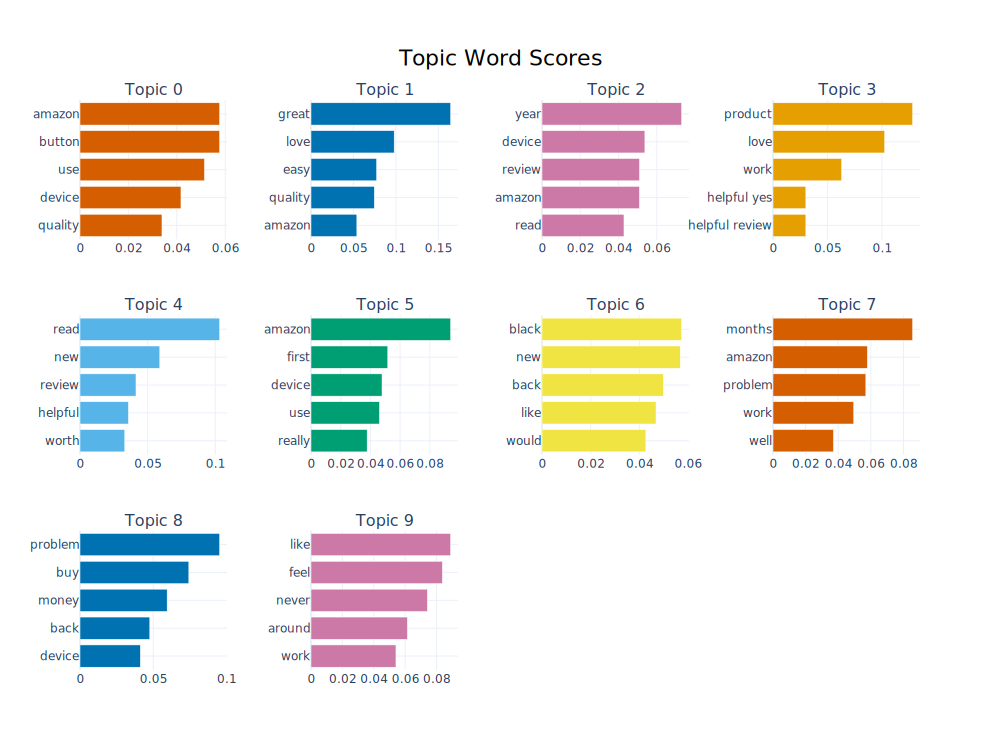

In [21]:
fig1 = topic_model.visualize_barchart(top_n_topics = 12)
fig1.show()

As suspected, some common words are clogging up our topics, such as 'fire' and 'sound'. We shall therefore enable `bm25_weighting` and `reduce_frequent_words` in the c-TF-IDF model.

Batches:   0%|          | 0/35 [00:00<?, ?it/s]

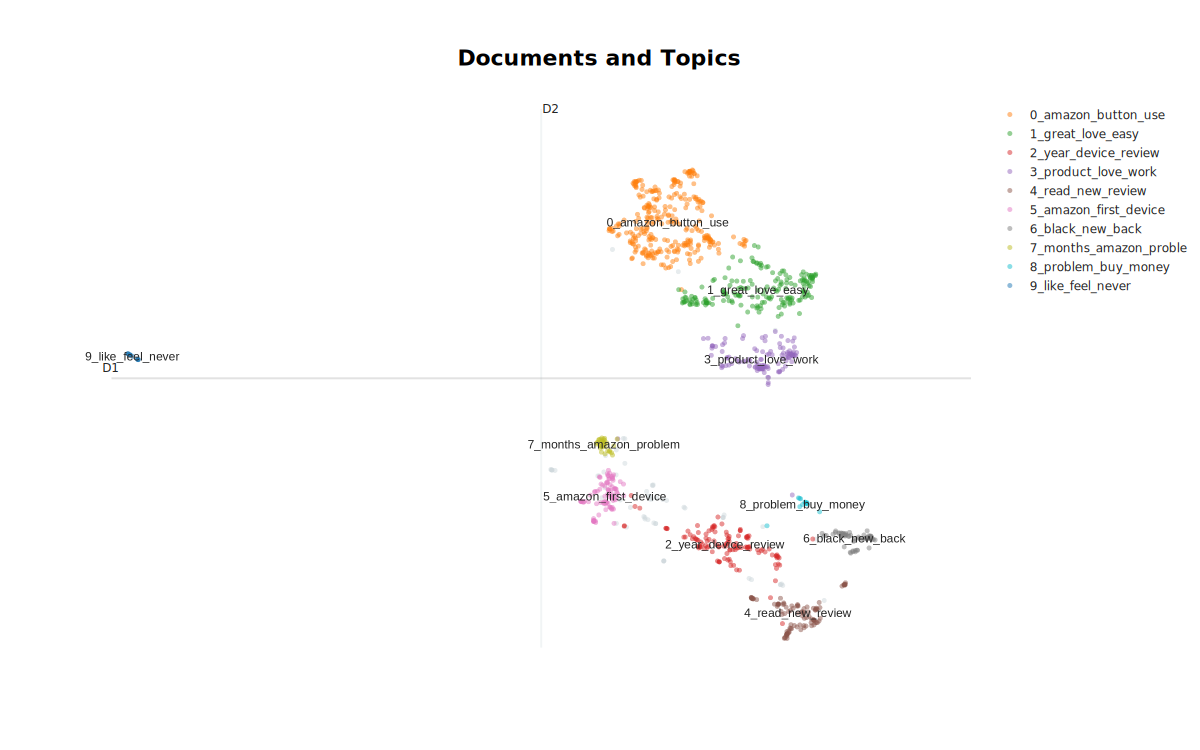

In [22]:
fig2 = topic_model.visualize_documents(docs)
fig2.show()

# 3. Hyperparameter tuning

Below, we set up automated hyperparameter tuning, with the goal of maximising coherence score.

We have the following hyperparameters that we need to tune. Since there are many different hyperparameters, we pick random combinations of values rather than iterating over all of them.

- UMAP: `min_dist` values of 0.0, 0.1, 0.25, 0.5; `n_neighbors` values of 15, 25, 50; `n_components` values of 3, 5, 10, 15, 20, 30.
- HDBSCAN: `min_cluster_size` values of 5, 10, 15, 20; `min_samples` values of `min_cluster_size * i` for i = 0.6, 0.8, 1, 1.2, 1.4;
- CountVectorizer: `ngram_range` values of (1,1), (1,2), (1,3); `min_df` values of 1, 2, 3, 5, 10.
- MaximalMarginalRelevance: `diversity` values of 0.1, 0.3, 0.5, 0.7, 0.9.
- BERTopic: `top_n_words` values of 10, 15, 20; `min_topic_size` values of 5, 10, 15, 20.

First, we set up a function to compute the coherence score of each model.

In [23]:
def calculate_coherence_score(topic_model, docs):
    os.environ["TOKENIZERS_PARALLELISM"] = "false"
    cleaned_docs = topic_model._preprocess_text(docs)
    vectorizer = topic_model.vectorizer_model
    analyzer = vectorizer.build_analyzer()
    tokens = [analyzer(doc) for doc in cleaned_docs]
    dictionary = corpora.Dictionary(tokens)
    corpus = [dictionary.doc2bow(token) for token in tokens]
    topics = topic_model.get_topics()
    topic_words = [[word for word, _ in topic_model.get_topic(topic)] for topic in topics]
    topic_words = [words for words in topic_words if len(words) > 0]

    coherence_model = CoherenceModel(topics=topic_words,
                                    texts=tokens,
                                    corpus=corpus,
                                    dictionary=dictionary,
                                    coherence='c_v')
    coherence = coherence_model.get_coherence()

    return coherence

Let's see the coherence score for our baseline version of the model.

In [24]:
score = calculate_coherence_score(topic_model, docs)

score

0.612253657792062

Next, we randomly iterate over the different hyperparameter values and return the ones with the top 5 coherence scores.

In [25]:
def train_bert(param_vals):
    topic_model = BERTopic(embedding_model=embedding_model,
                           umap_model=UMAP(n_neighbors=param_vals['n_neighbors'], n_components=param_vals['n_components'], min_dist=param_vals['min_dist'], metric='cosine', low_memory=False, random_state=23),
                           hdbscan_model=HDBSCAN(min_cluster_size=param_vals['min_cluster_size'], min_samples=int(param_vals['min_samples_mult'] * param_vals['min_cluster_size']), metric=param_vals['metric'], cluster_selection_method='eom', prediction_data=True),
                           vectorizer_model=CountVectorizer(stop_words=stopwords.words('english'), ngram_range=param_vals['ngram_range'], min_df=param_vals['min_df'], max_features=10_000),
                           ctfidf_model=ClassTfidfTransformer(bm25_weighting=True, reduce_frequent_words=True),
                           representation_model=MaximalMarginalRelevance(diversity=param_vals['diversity']),
                           top_n_words=param_vals['top_n_words'],
                           min_topic_size=param_vals['min_topic_size'],
                           language='english')

    topics, probs = topic_model.fit_transform(docs, embeddings)
    
    return topic_model

In [26]:
param_ranges = {'min_dist': [0.0, 0.1, 0.25, 0.5], 'n_neighbors': [15,25,50], 'n_components': [3,5,10,15,20,30], 
                'min_cluster_size': [5,10,15,20], 'min_samples_mult': [0.6,0.8,1.0,1.2,1.4], 'metric': ['euclidean'],
                'ngram_range': [(1,1), (1,2), (1,3)], 'min_df': [1,2,3,5,10],
                'diversity': [0.1,0.3,0.5,0.7,0.9],
                'top_n_words': [10,15,20], 'min_topic_size': [5,10,15,20]}

top_5 = [(topic_model, score, {})] * 5

for i in range(1000):
    param_vals = {param: param_ranges[param][np.random.randint(len(param_ranges[param]))] for param in param_ranges}
    try:
        topic_model = train_bert(param_vals)
        score = calculate_coherence_score(topic_model, docs)
    except:
        continue
    if score > top_5[-1][1] and len(topic_model.get_topics()) > 3:
        top_5[-1] = (topic_model, score, param_vals)
        top_5 = sorted(top_5, key=lambda x: x[1], reverse=True)
        
print(f'Top 5 scores: {top_5[0][1]}, {top_5[1][1]}, {top_5[2][1]}, {top_5[3][1]}, {top_5[4][1]}')
print(f'Top 5 parameter values:\n {top_5[0][2]},\n {top_5[1][2]},\n {top_5[2][2]},\n {top_5[3][2]},\n {top_5[4][2]}')

Top 5 scores: 0.7542150805949386, 0.7406948034596994, 0.7292861178973205, 0.708496614138924, 0.7039871627876698
Top 5 parameter values:
 {'min_dist': 0.5, 'n_neighbors': 50, 'n_components': 10, 'min_cluster_size': 20, 'min_samples_mult': 0.8, 'metric': 'euclidean', 'ngram_range': (1, 3), 'min_df': 2, 'diversity': 0.9, 'top_n_words': 15, 'min_topic_size': 20},
 {'min_dist': 0.5, 'n_neighbors': 50, 'n_components': 3, 'min_cluster_size': 20, 'min_samples_mult': 1.2, 'metric': 'euclidean', 'ngram_range': (1, 3), 'min_df': 2, 'diversity': 0.7, 'top_n_words': 10, 'min_topic_size': 5},
 {'min_dist': 0.1, 'n_neighbors': 15, 'n_components': 10, 'min_cluster_size': 10, 'min_samples_mult': 0.6, 'metric': 'euclidean', 'ngram_range': (1, 3), 'min_df': 10, 'diversity': 0.3, 'top_n_words': 20, 'min_topic_size': 15},
 {'min_dist': 0.25, 'n_neighbors': 50, 'n_components': 10, 'min_cluster_size': 15, 'min_samples_mult': 0.8, 'metric': 'euclidean', 'ngram_range': (1, 3), 'min_df': 5, 'diversity': 0.7, 't

Finally, we manually inspect each of these five models to see which looks best.

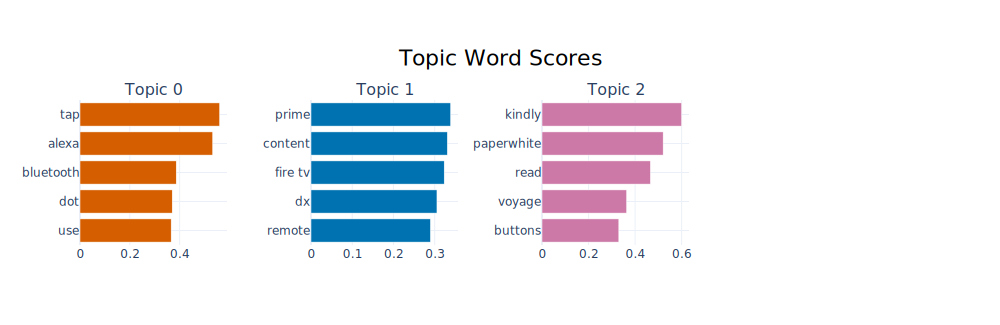

In [27]:
fig = top_5[0][0].visualize_barchart(top_n_topics = 12)
fig.show()

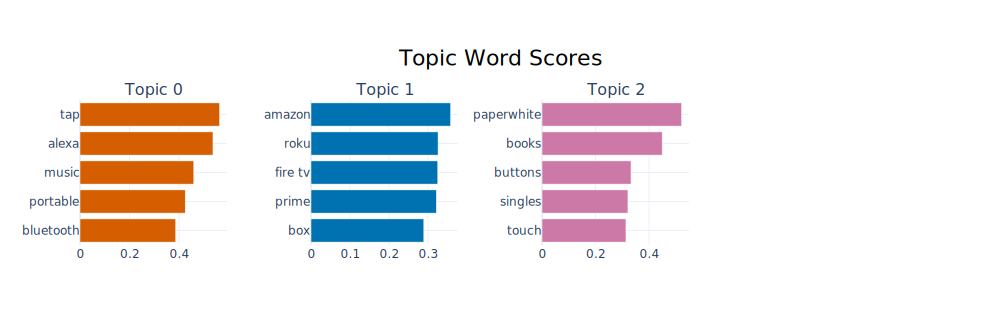

In [28]:
fig = top_5[1][0].visualize_barchart(top_n_topics = 12)
fig.show()

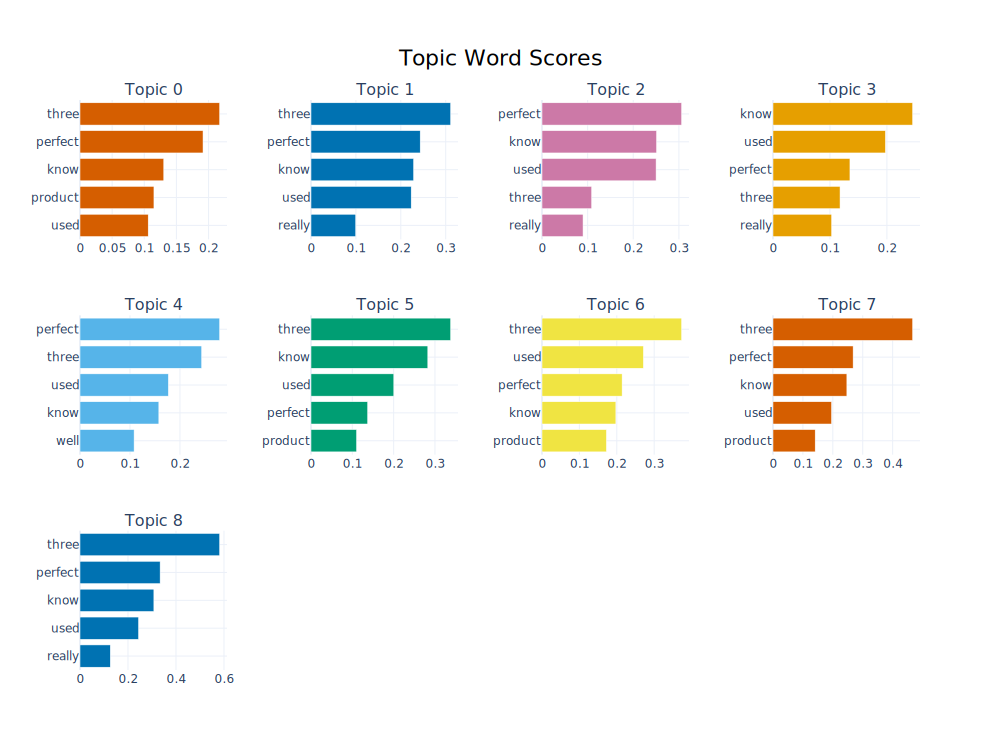

In [29]:
fig = top_5[2][0].visualize_barchart(top_n_topics = 12)
fig.show()

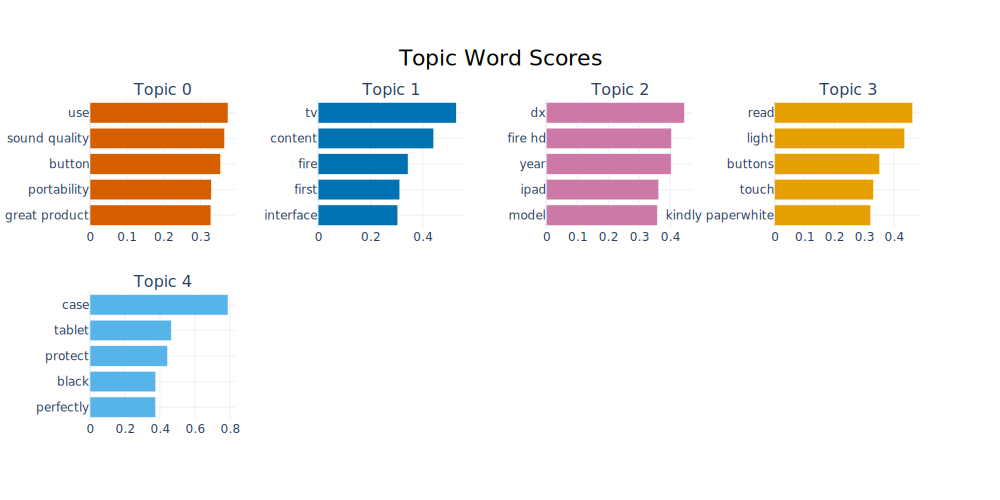

In [30]:
fig = top_5[3][0].visualize_barchart(top_n_topics = 12)
fig.show()

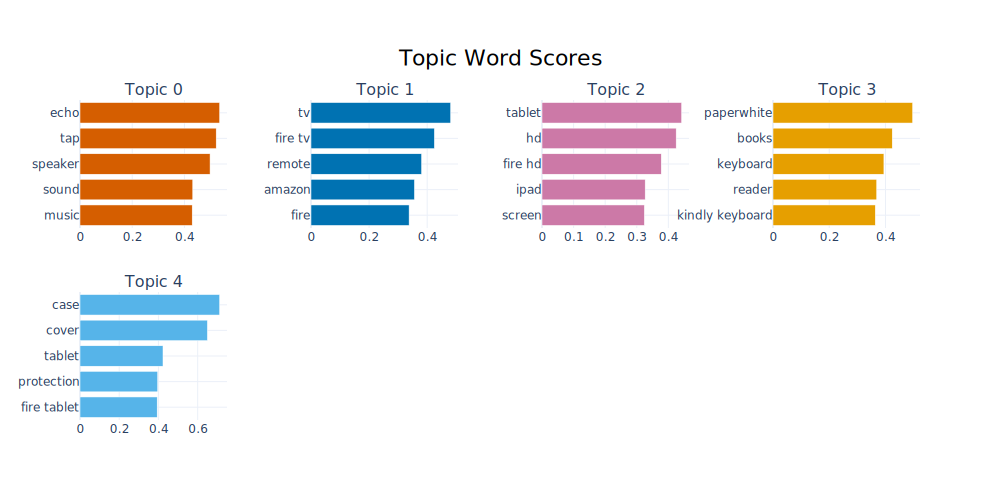

In [31]:
fig = top_5[4][0].visualize_barchart(top_n_topics = 12)
fig.show()

# 4. Conclusion

After trying 1000 different hyperparameter combinations, the best topic model we found has the following hyperparameters (these will change a bit each time you run the notebook due to the randomness of the hyperparameter tuning).

- UMAP: `min_dist = 0.5`; `n_neighbors = 50`; `n_components = 3`.
- HDBSCAN: `min_cluster_size = 10`; `min_samples = min_cluster_size`;
- CountVectorizer: `ngram_range = (1,3)`; `min_df = 3`.
- MaximalMarginalRelevance: `diversity = 0.1`.
- BERTopic: `top_n_words = 20`; `min_topic_size = 15`.

The model generated six topics, which appear to roughly correspond to:

- Voice assistants
- Television
- Reading
- Tablets
- Accessories
- Audio

We display the visualisation for these topics below. Since there is some randomness involved in the generated model, we load one that we saved on an earlier run.

In [32]:
## Run these lines instead if you want to try training the model from scratch with the above hyperparameters.
# param_vals = {'min_dist': 0.5, 'n_neighbors': 50, 'n_components': 3, 'min_cluster_size': 10, 'min_samples_mult': 1.0, 'metric': 'euclidean', 'ngram_range': (1, 3), 'min_df': 3, 'diversity': 0.1, 'top_n_words': 20, 'min_topic_size': 15}
# topic_model = train_bert(param_vals)

docs = joblib.load('../input/pre-trained-model/clean_docs')
topic_model = joblib.load('../input/pre-trained-model/amazon_topic_model')

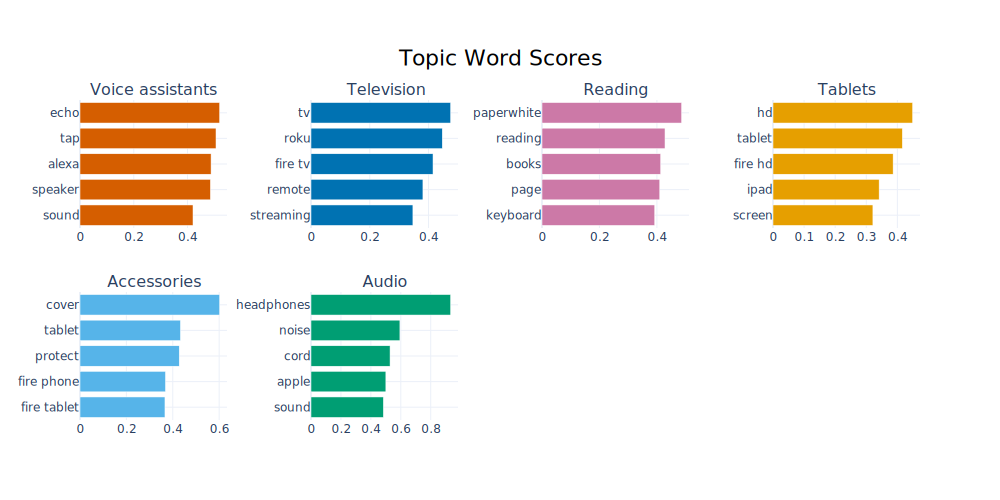

In [33]:
topic_model.set_topic_labels({0: 'Voice assistants', 1: 'Television', 2: 'Reading', 3: 'Tablets', 4: 'Accessories', 5: 'Audio'})

fig1 = topic_model.visualize_barchart(top_n_topics = 12, custom_labels=True)
fig1.show()

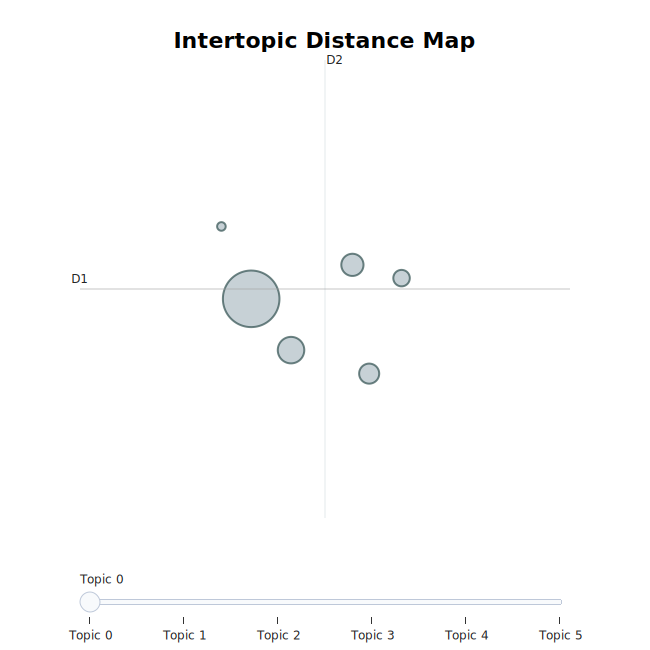

In [34]:
fig2 = topic_model.visualize_topics(custom_labels=True)
fig2.show()

Batches:   0%|          | 0/35 [00:00<?, ?it/s]

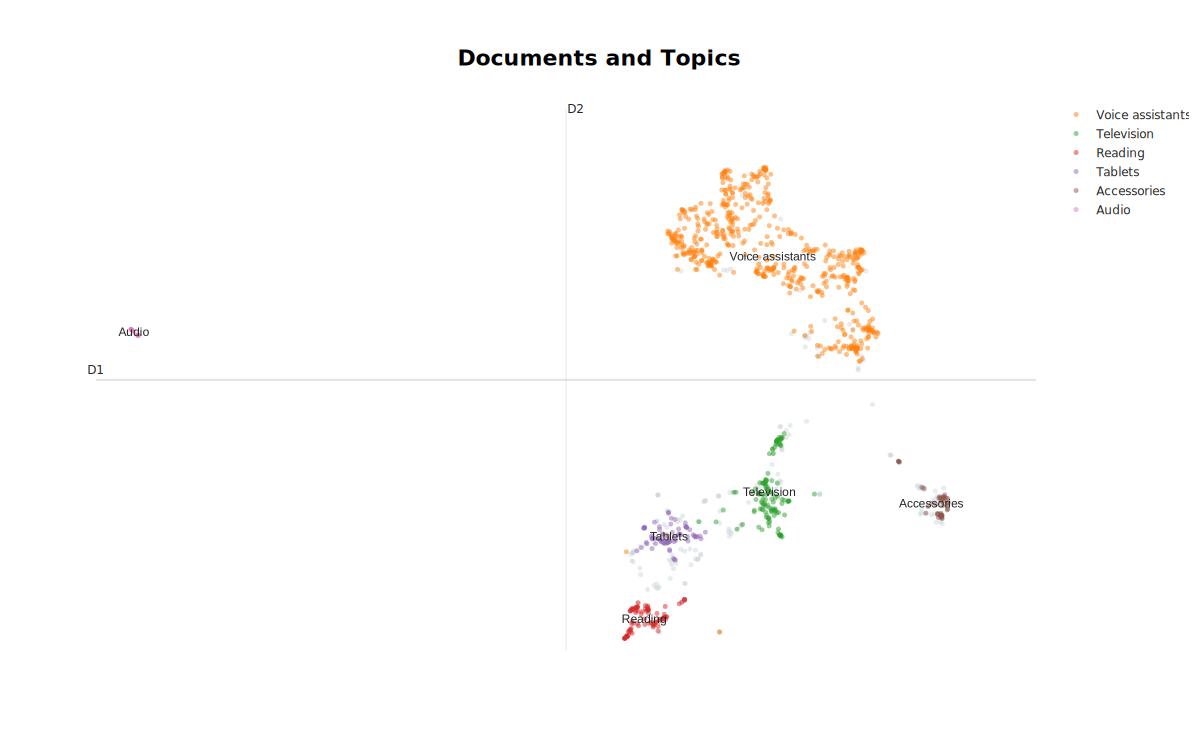

In [35]:
fig3 = topic_model.visualize_documents(docs, custom_labels=True, hide_document_hover=False)
fig3.show()

We can see that we now have very clearly-defined topics, which are separated into distinct clusters. Excellent! We can also see that there is a sub-cluster of the `Television` topic about remote controls, so there is potential to split that topic in two.